# Final Project GAN


In [ ]:
!pip install jovian --upgrade -q
import jovian

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
from torchvision.datasets import ImageFolder, CIFAR10
from torchvision import transforms
from torch import autograd
import torch.optim.lr_scheduler as lr_sh
from torch.autograd import Variable
from torchvision.utils import make_grid

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(CIFAR10('data', train=True, download=True, transform=transform),
                                          batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

stats = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

100%|██████████| 170498071/170498071 [00:12<00:00, 13262111.95it/s]


Extracting data/cifar-10-python.tar.gz to data


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Conv2d(10+3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x, labels):
        c = self.label_emb(labels)
        c = c.view(c.size(0), 10, 1, 1)
        c = c.expand(c.size(0), 10, 32, 32)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.view(out.size(0), -1)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(110, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 256 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 128 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 64 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                init.xavier_uniform_(m.weight)

    def forward(self, z, labels):
        z = z.view(z.size(0), 100, 1, 1)
        c = self.label_emb(labels)
        c = c.view(c.size(0), 10, 1, 1)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()
d_losses=[]
g_losses=[]

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.4,0.9), weight_decay=0.02)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0,0.999), weight_decay=0.0001)
scheduler = lr_sh.StepLR(d_optimizer, 14, 0.82)

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, real_images):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones([batch_size,1])).cuda())
    l1_lambda = 0.0001  # Adjust lambda as needed
    l1_loss = 0
    #l1_loss = torch.nn.L1Loss()(fake_images, real_images)
    g_loss += l1_lambda * l1_loss
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones([batch_size,1])).cuda())

    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros([batch_size,1])).cuda())

    d_loss = real_loss + fake_loss
    l2_lambda = 0.005  # Adjust lambda as needed
    l2_loss = 0
    for param in discriminator.parameters():
        l2_loss += (param ** 2).sum()
    d_loss += l2_lambda * l2_loss

    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [ ]:
num_epochs = 180
n_critic = 1
display_step = 50
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):

        step = epoch * len(data_loader) + i + 1
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()

        d_loss = 0

        d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)

        for _ in range(n_critic):
          g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, real_images)

        if step % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(9, 100)).cuda()
            labels = Variable(torch.LongTensor(np.arange(9))).cuda()
            sample_images = generator(z, labels).unsqueeze(1)
            sample_images = sample_images.view(-1, 3, 32, 32)
            grid = make_grid(denorm(images.detach()[:100]), nrow=3)
    scheduler.step()
    g_losses.append(g_loss)
    d_losses.append(d_loss)
    print('Done!', g_loss, d_loss)

Starting epoch 0... Done! 2.0935654640197754 7.653037071228027
Starting epoch 1... Done! 1.3623056411743164 5.049070358276367
Starting epoch 2... Done! 0.8797194957733154 4.109977722167969
Starting epoch 3... Done! 2.24790096282959 3.4161221981048584
Starting epoch 4... Done! 1.2288004159927368 2.440662145614624
Starting epoch 5... Done! 1.75166654586792 1.965627908706665
Starting epoch 6... Done! 1.9993693828582764 1.9265635013580322
Starting epoch 7... Done! 1.7366867065429688 1.617966651916504
Starting epoch 8... Done! 0.751946210861206 1.6648435592651367
Starting epoch 9... Done! 1.286281943321228 1.4504079818725586
Starting epoch 10... Done! 1.5670723915100098 1.4311108589172363
Starting epoch 11... Done! 0.5824949741363525 1.4288296699523926
Starting epoch 12... Done! 1.2444132566452026 1.2174049615859985
Starting epoch 13... Done! 3.084148406982422 1.139053463935852
Starting epoch 14... Done! 1.1602849960327148 1.077197790145874
Starting epoch 15... Done! 1.427647352218628 1.209

In [ ]:
torch.save(generator.state_dict(), 'generator_state.pt')
torch.save(discriminator.state_dict(), 'discriminator_state.pt')

Text(0.5, 1.0, 'Losses')

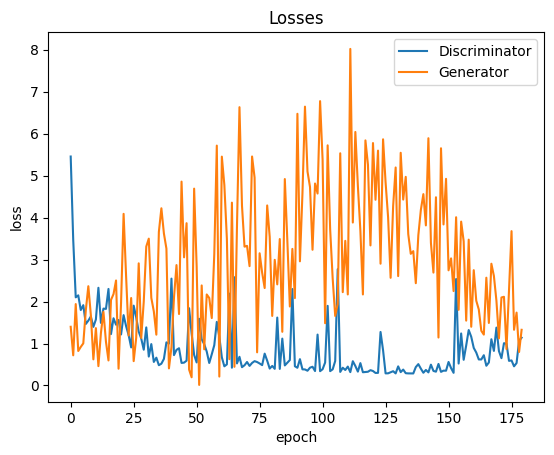

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [ ]:
z = Variable(torch.randn(100, 100)).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()

In [ ]:
images = generator(z, labels).unsqueeze(1)
images = images.view(-1, 3, 32, 32)

In [ ]:
grid = make_grid(denorm(images.detach()[:100]), nrow=10)

(-0.5, 341.5, 341.5, -0.5)

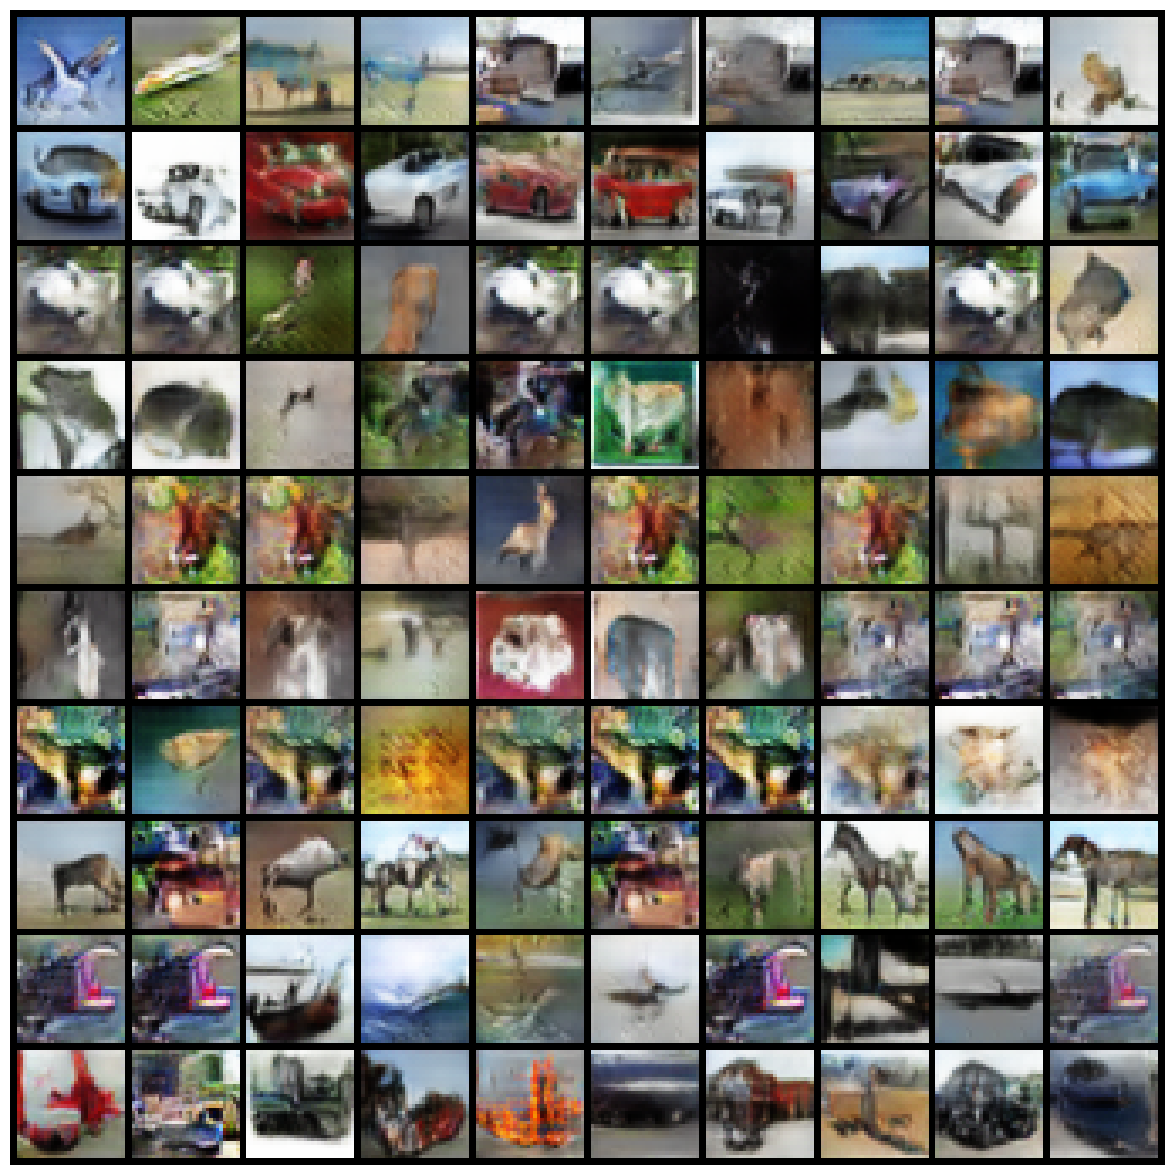

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid.permute(1, 2, 0).cpu().data, cmap='binary')
ax.axis('off')

In [ ]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 100)).cuda()
    label = torch.LongTensor([digit]).cuda()
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

In [ ]:
 generate_digit(generator, 8)

ValueError: ignored

In [ ]:
jovian.commit(project='final-project-gan', environment=None)